Python environment

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scvi
import hotspot

In [ ]:
sc.settings.n_jobs = 8

In [ ]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [ ]:
import matplotlib as mpl
# https://github.com/theislab/scanpy/issues/1720
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Read pre-processed data

In [ ]:
tmp = sc.read('data/core_GBmap.h5ad')

# filter the vascular population
cells = pd.read_csv('data/filtered_vascular.csv')
tmp.obs['cells'] = tmp.obs.index.values
adata = tmp[tmp.obs['cells'].isin(cells['cells'].values.tolist())].copy()
print(adata)

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1000,
    batch_key="author",
    layer="counts",
    subset=True)

... storing 'cell_type' as categorical
/hpc/pmc_stunnenberg/cruiz/miniconda3/envs/scarches/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:240: RuntimeWarning: divide by zero encountered in true_divide
  ) / disp_std_bin[df['mean_bin'].values].values


### Create SCVI model and train it on reference dataset

In [ ]:
sca.dataset.setup_anndata(adata, layer = 'counts', batch_key="author")

In [ ]:
vae = sca.models.SCVI(
    adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
    use_cuda = True # indicate to use gpu!
)

In [ ]:
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
vae.train(n_epochs=500, frequency=1, early_stopping_kwargs=early_stopping_kwargs)

INFO     Training for 500 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...:  21%|██        | 106/500 [00:15<00:56,  6.96it/s]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  21%|██        | 106/500 [00:15<00:57,  6.83it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  10 s. / 500 epochs                                                  


In [ ]:
reference_latent = sc.AnnData(vae.get_latent_representation())

In [ ]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent, resolution = 1)
sc.tl.umap(reference_latent)

In [ ]:
reference_latent.obsm['X_scVI'] = vae.get_latent_representation()

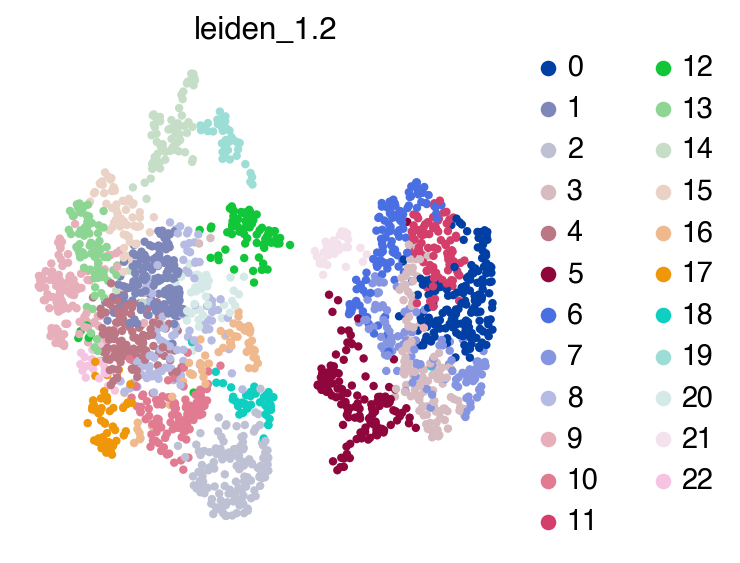

In [ ]:
sc.tl.leiden(reference_latent, resolution = 1.2, key_added= 'leiden_1.2')
sc.pl.umap(reference_latent,
           color=['leiden_1.2'],
           frameon=False,
           wspace=0.6,
           )

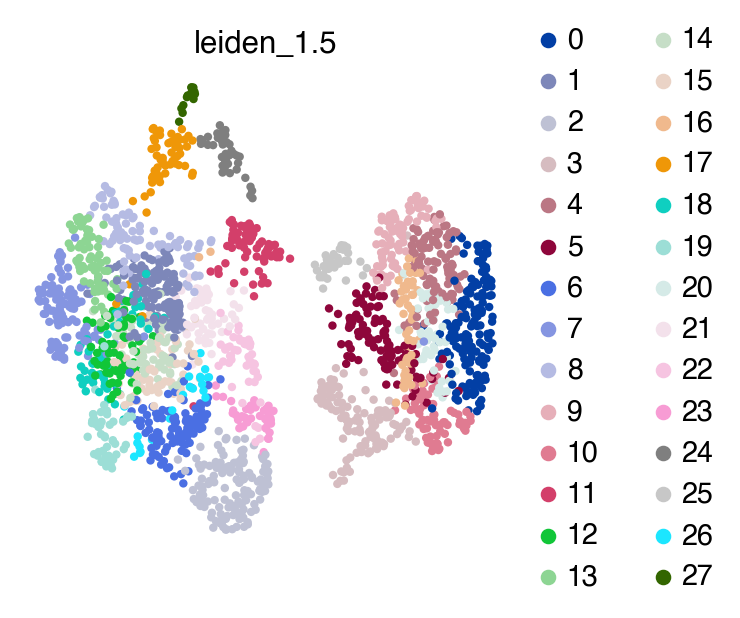

In [ ]:
sc.tl.leiden(reference_latent, resolution = 1.5, key_added= 'leiden_1.5')
sc.pl.umap(reference_latent,
           color=['leiden_1.5'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
reference_latent.write_h5ad('data/vascular_SCVI_1000hvg.5had')

In [ ]:
latent = vae.get_latent_representation()
counts = pd.DataFrame(adata.layers['counts'].astype('float64').todense().transpose(), columns=adata.obs.index.values, 
                      index=adata.var_names)
scvi_data = pd.DataFrame(latent,index=adata.obs.index.values)

### Creating the Hotspot object

In [ ]:
# Create the Hotspot object and the neighborhood graph
hs = hotspot.Hotspot(counts, model='danb', latent=scvi_data)

In [ ]:
hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

### Determining informative genes

In [ ]:
hs_results = hs.compute_autocorrelations(jobs=18)

hs_results.head(15)

100%|██████████| 1000/1000 [00:06<00:00, 165.82it/s]


,C,Z,Pval,FDR
Gene,,,,
MIR4435-2HG,0.561521,2233.471739,0.0,0.0
CLU,0.677119,2187.390848,0.0,0.0
PLCG2,0.131095,2122.018345,0.0,0.0
POSTN,0.460838,1274.863096,0.0,0.0
MALAT1,0.494346,1195.036981,0.0,0.0
CYTOR,0.531706,1068.955462,0.0,0.0
NDUFA4L2,0.700855,890.478655,0.0,0.0
CRYAB,0.530355,858.992729,0.0,0.0
MYL9,0.546604,850.879795,0.0,0.0


### Grouping genes into lineage-based modules

In [ ]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=18)

100%|██████████| 500/500 [00:00<00:00, 12527.49it/s]

Computing pair-wise local correlation on 500 features...



100%|██████████| 124750/124750 [00:27<00:00, 4476.88it/s]


In [ ]:
modules = hs.create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

 4     72
-1     70
 1     68
 3     62
 10    43
 12    38
 5     29
 9     24
 11    23
 2     20
 8     19
 7     17
 6     15
Name: Module, dtype: int64

### Plotting module correlations

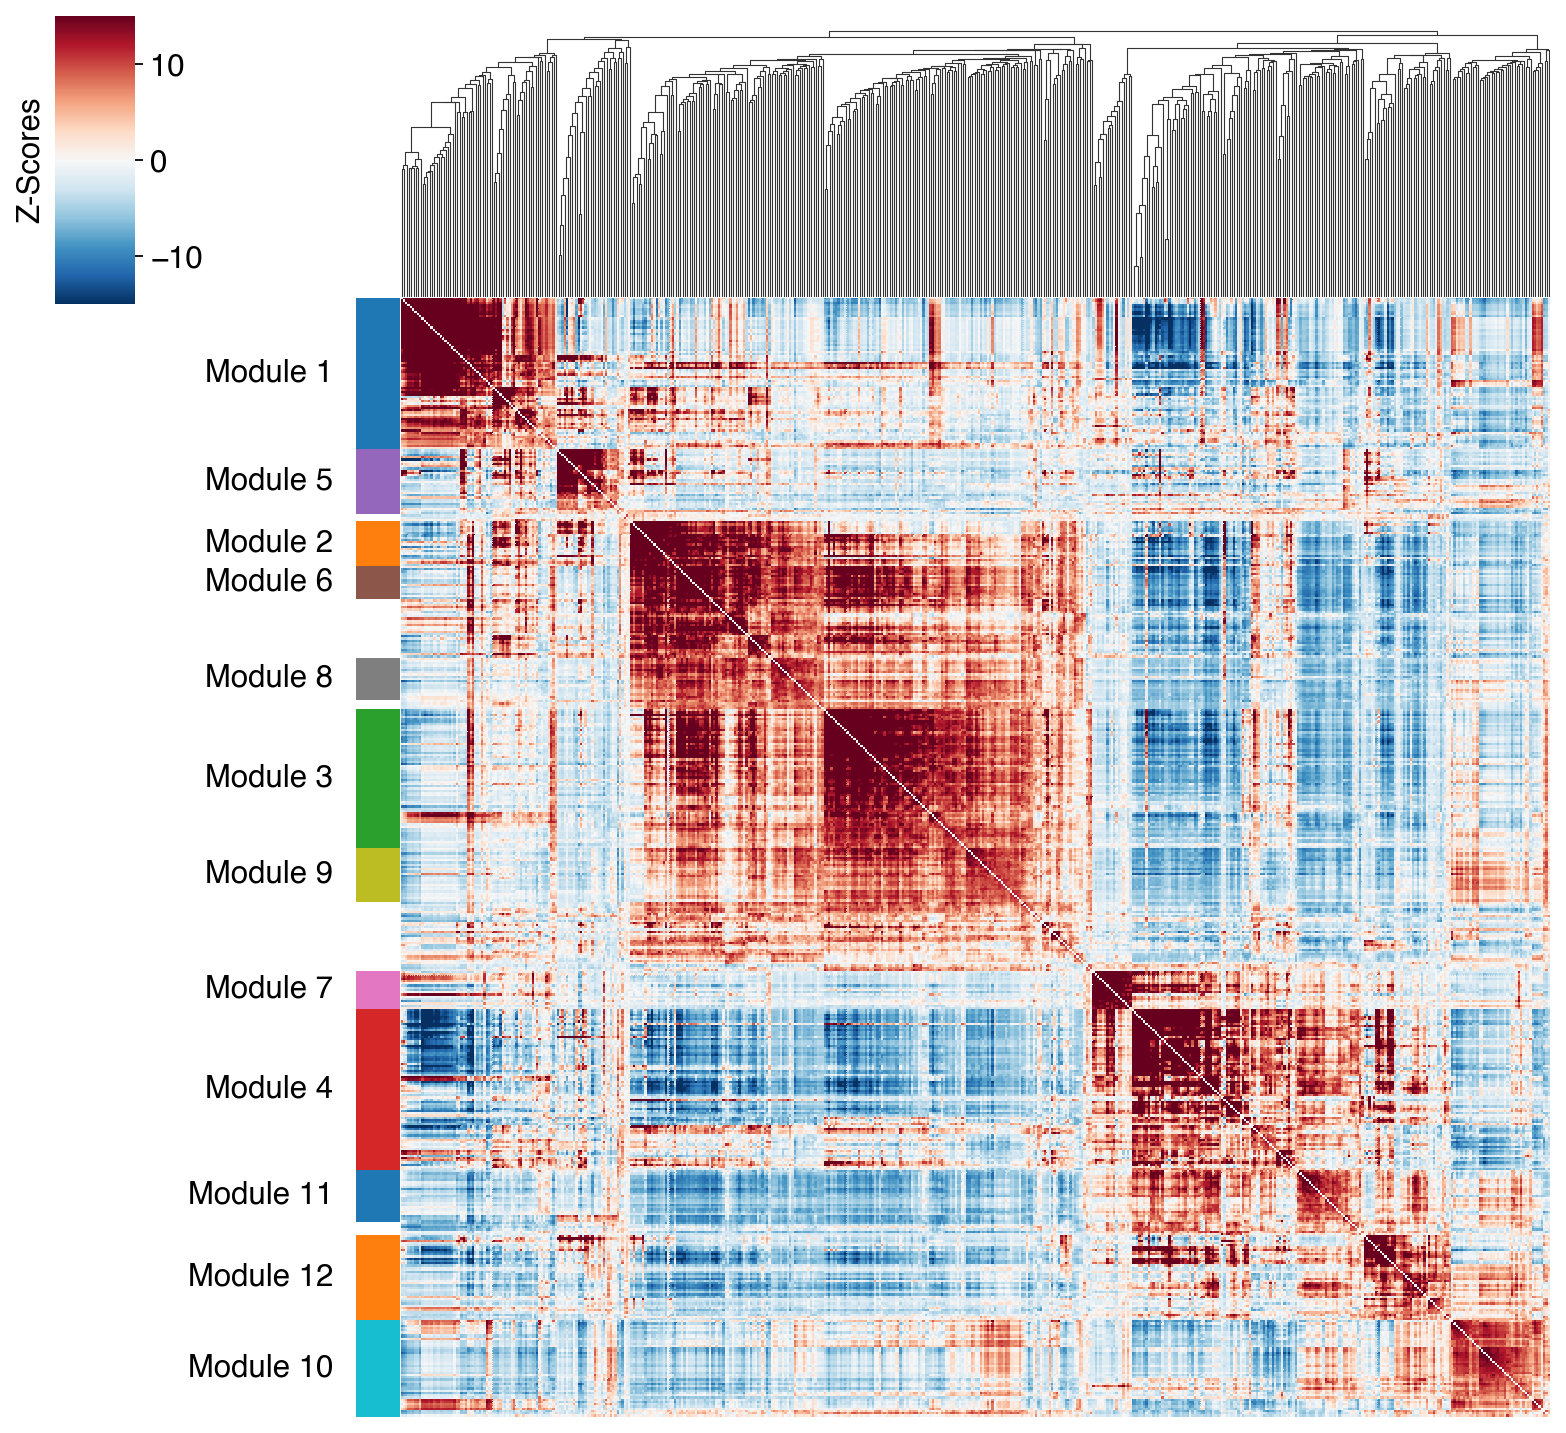

In [ ]:
hs.plot_local_correlations(vmin=-15, vmax=15)
plt.savefig('figures/vascular_plot_local_correlations.pdf')
# In the manuscript, the number of the modules where arranged in order from top to bottom

In [ ]:
# Show the top genes for a module

module = 1

results = hs.results.join(hs.modules)
results.to_csv('data/vascular_modules_hotspot_1000hvg.csv')

results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

,C,Z,Pval,FDR,Module
Gene,,,,,
GFAP,0.376063,691.442814,0.0,0.0,1.0
SPP1,0.362994,538.144766,0.0,0.0,1.0
C1QB,0.239813,322.924100,0.0,0.0,1.0
CD74,0.674621,317.572971,0.0,0.0,1.0
HLA-DRA,0.759974,316.109628,0.0,0.0,1.0
RGS1,0.729348,287.030240,0.0,0.0,1.0
S100A9,0.186293,271.275828,0.0,0.0,1.0
LYZ,0.733482,269.891552,0.0,0.0,1.0
C1QC,0.651375,265.079100,0.0,0.0,1.0


### Summary Module Scores

In [ ]:
module_scores = hs.calculate_module_scores()

module_scores.head()

  0%|          | 0/12 [00:00<?, ?it/s]

Computing scores for 12 modules...


100%|██████████| 12/12 [00:00<00:00, 20.43it/s]


,1,2,3,4,5,6,7,8,9,10,11,12
PJ017_6,-0.581944,-1.933252,-2.250000,3.058956,0.660658,-1.532946,-1.224944,-0.778388,-0.963256,-0.517244,1.124043,0.673111
PJ017_82,-2.671451,-2.130513,-1.893909,7.921406,-0.416303,-1.375805,5.768343,-0.826824,-0.815930,-0.107785,1.545656,-0.110177
PJ017_148,-1.748095,-1.668938,-1.725791,4.801701,-0.458675,-1.467776,-1.110638,-0.942889,-0.724676,-0.207841,0.599842,2.897018
PJ017_157,0.748578,5.504411,0.102824,-5.858505,-0.524871,2.388025,-1.334360,1.381711,0.670706,0.517324,-1.488651,-1.438267
PJ017_239,-1.696264,6.455093,3.297297,-4.804187,-0.669640,3.979950,-1.202487,2.192838,2.237028,0.238866,-1.172113,-1.540223


In [ ]:
module_scores.to_csv('data/vascular_modules_scores_hotspot.csv')